# Quantum teleportation demo using SQUANCH

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from squanch.agent import *
from squanch.gates import *
from squanch.qstream import *
% matplotlib inline

We'll be implementing this quantum teleportation scheme:

![Teleportation circuit](https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Quantum_teleportation_circuit.svg/700px-Quantum_teleportation_circuit.svg.png)

Alice will have the original qubit to be teleported and half of a Bell pair (she sends the other half to Bob prior to the teleportation).

In [2]:
class Alice(Agent):
    '''Alice sends qubits to Bob using a shared Bell pair'''

    def teleport(self, qSystem):
        # Generate a Bell pair and send half of it to Bob
        q, a, b = qSystem.qubits
        H(a)
        CNOT(a, b)
        self.qsend(bob, b)
        # Perform the teleportation
        CNOT(q, a)
        H(q)
        bobZ = q.measure() # If Bob should apply Z
        bobX = a.measure() # If Bob should apply X
        self.csend(bob, [bobX, bobZ])

    def run(self):
        for qSys in self.stream:
            self.teleport(qSys)


class Bob(Agent):
    '''Bob receives qubits from Alice and measures the results'''

    def run(self):
        measurementResults = []
        for _ in self.stream:
            b = self.qrecv(alice)
            doX, doZ = self.crecv(alice)
            if doX and b is not None: X(b)
            if doZ and b is not None: Z(b)
            measurementResults.append(b.measure())
        self.output(measurementResults)

### Simple demonstration

In [3]:
# Allocate memory and output structures
mem = sharedHilbertSpace(3, 10)
out = sharedOutputDict()

# Prepare the initial states
stream = QStream.fromArray(mem)
statesList = [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]
for state, qSys in zip(statesList, stream):
    q = qSys.qubit(0)
    if state == 1: X(q)  # Flip the qubits corresponding to 1's

# Make the agents
alice = Alice(mem)
bob = Bob(mem, out = out)

# Connect the agents
connectAgents(alice, bob, length = 0.0)

# Run everything
alice.start(); bob.start()
alice.join(); bob.join()

print "Teleported states {} \n" \
      "Received states   {}".format(statesList, out["Bob"])

Teleported states [1, 0, 1, 0, 1, 0, 1, 0, 1, 0] 
Received states   [1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


### Rotation demonstration

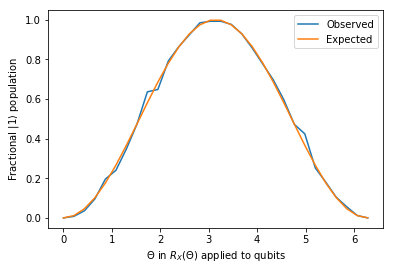

In [4]:
angles = np.linspace(0, 2 * np.pi, 30)  # RX angles to apply
numTrials = 250  # number of trials for each angle

# Allocate memory and output structures
mem = sharedHilbertSpace(3, len(angles) * numTrials)
out = sharedOutputDict()

# Prepare the initial states in the stream
stream = QStream.fromArray(mem)
for angle in angles:
    for _ in range(numTrials):
        q = stream.head().qubit(0)
        RX(q, angle)
stream.index = 0  # reset the head counter

# Make the agents
alice = Alice(mem)
bob = Bob(mem, out = out)

# Connect the agents
connectAgents(alice, bob)

# Run everything
alice.start(); bob.start()
alice.join(); bob.join()

results = np.array(out["Bob"]).reshape((len(angles), numTrials))
meanResults = np.mean(results, axis = 1)
expectedResults = np.sin(angles / 2) ** 2
plt.plot(angles, meanResults, label = 'Observed')
plt.plot(angles, expectedResults, label = 'Expected')
plt.legend()
plt.xlabel("$\Theta$ in $R_X(\Theta)$ applied to qubits")
plt.ylabel("Fractional $\left | 1 \\right >$ population")
plt.show()